# Semantic Image Segmentation Models

## Setup

In [1]:
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from PIL import Image
from tensorflow.keras.optimizers import Adam

from project_utils import *
from SatelliteImageData import *

%reload_ext autoreload
%autoreload 2

sys.path.append('../lib/')

random.seed(0)
np.set_printoptions(suppress=True)
weights = [0.001, 0.0033, 0.0053, 0.0015, 0.0003, 0.0002, 0.0088, 0.0248, 0.8125, 0.1423]

K.set_image_data_format('channels_last')
tf.get_logger().setLevel('ERROR')
strategy = tf.distribute.MirroredStrategy()

## Create Dataset

In [2]:
from SatelliteImageData import SatelliteImageData

data_root_dir = '../../datasets/dstl-satellite-imagery-feature-detection/'
img_data = SatelliteImageData(data_root_dir)

labelled_patch_ids = list(np.load(img_data.processed_data_dir + 'labelled_patch_ids.npy'))
unlabelled_patch_ids = list(np.load(img_data.processed_data_dir + 'unlabelled_patch_ids.npy'))

full_id_list = labelled_patch_ids
random.shuffle(full_id_list)
splitted_id_list = split_list(full_id_list, split_ratio=(0.8, 0.1, 0.1))

data_generators = []
for id_list in splitted_id_list:
    data_generators.append(SlicedSatelliteDataGenerator(img_data.processed_data_dir,
                                                        id_list,
                                                        input_shape=(256,256,8),
                                                        num_classes=10,
                                                        batch_size=10))

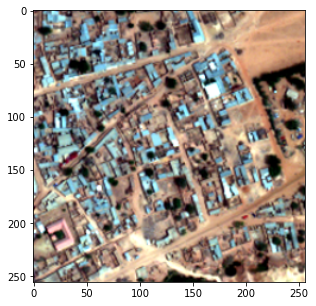

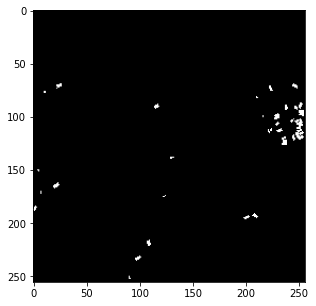

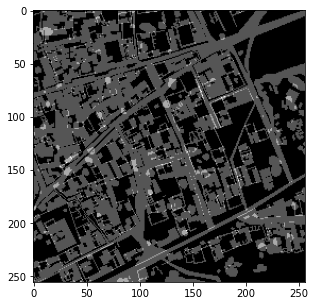

In [3]:
import cv2

temp_img_id = '6120_2_2'
img_size = (1024, 1024)
patch_shape=(256, 256)
patch_coord=(1, 3)

temp_img = img_data.get_visual_m_band_img(temp_img_id)
temp_img = cv2.resize(temp_img, img_size, interpolation=cv2.INTER_LINEAR)
temp_stacked_masks = img_data.get_stacked_masks(img_size, temp_img_id)

temp_img_patch = get_patch(temp_img, patch_shape, patch_coord)
temp_masks_patch = get_patch(temp_stacked_masks, patch_shape, patch_coord)

display_rgb_img(temp_img_patch)
display_mask(temp_masks_patch[:,:,9])
display_stacked_masks(temp_masks_patch)

temp_p_img = img_data.get_m_band_img(temp_img_id)
temp_p_img = img_data.stretch_n_bit(temp_p_img)
temp_p_img = cv2.resize(temp_p_img, img_size, interpolation=cv2.INTER_LINEAR)
temp_p_img_patch = get_patch(temp_p_img, patch_shape, patch_coord)
temp_p_img_patch = temp_p_img_patch[np.newaxis, ...]

## Models

## Unet

In [4]:
from keras_unet.models import satellite_unet

with strategy.scope():
    unet_model = satellite_unet(
        input_shape=(256, 256, 8),
        num_classes=10,
    )

    unet_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=weighted_categorical_crossentropy(weights),
        metrics=['accuracy', calc_mean_iou]
    )

# unet_history = unet_model.fit(
#     data_generators[0],
#     epochs=200,
#     validation_data=data_generators[1]
# )

# plt.plot(unet_history.history['loss'])

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [5]:
# unet_model.save_weights('saved_weights/unet_base.h5')

4/4 [==============================] - 0s 90ms/step - loss: 9.4043e-04 - accuracy: 0.4553 - calc_mean_iou: 0.1709
tf.Tensor(
[0.09145364 0.02662116 0.18896309 0.04642319 0.37008095 0.56037897
 0.29826933 0.12637512 0.00002139 0.00042333], shape=(10,), dtype=float32)
0.17090102


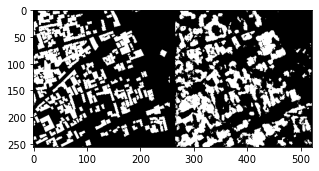

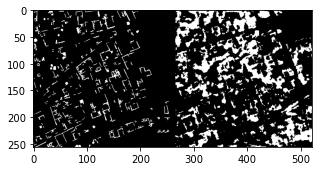

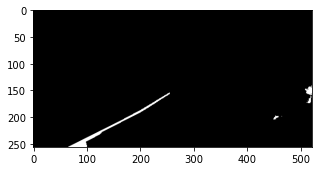

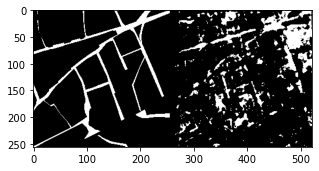

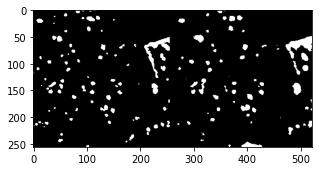

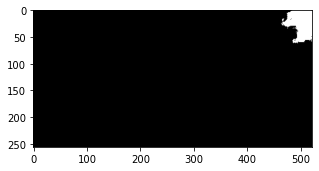

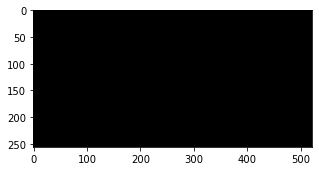

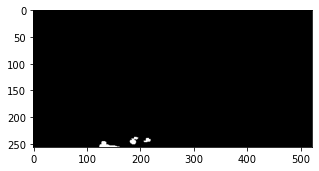

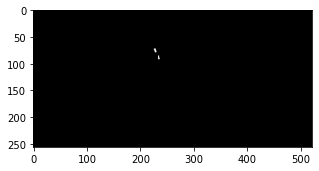

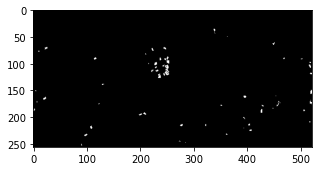

In [6]:
unet_model.load_weights('saved_weights/baseline_weights/unet_base.h5')

unet_model.evaluate(data_generators[2])
iou = evaluate_iou(data_generators[2], unet_model)
print(iou)
print(np.mean(iou))

unet_prediction = unet_model.predict(temp_p_img_patch)
unet_tmp_p_masks = unet_prediction[0]
unet_tmp_p_masks[unet_tmp_p_masks > 0.3] = 1
unet_tmp_p_masks[unet_tmp_p_masks <= 0.3] = 0

for i in range(10):
    maerged_mask = np.concatenate([temp_masks_patch[:,:,i], np.zeros((256,10)), unet_tmp_p_masks[:,:,i]], axis=1)
    display_mask(maerged_mask)

### FCN

In [7]:
from image_segmentation_keras.keras_segmentation.models.fcn import fcn_8_vgg

with strategy.scope():
    fcn_model = fcn_8_vgg(
        input_height=256,
        input_width=256,
        input_channels=8,
        n_classes=10
    )

    fcn_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=weighted_categorical_crossentropy(weights),
        metrics=['accuracy', calc_mean_iou]
    )

# fcn_history = fcn_model.fit(
#     data_generators[0],
#     epochs=200,
#     validation_data=data_generators[1]
# )

# plt.plot(fcn_history.history['loss'])

In [8]:
# fcn_model.save_weights('saved_weights/fcn_base.h5')

4/4 [==============================] - 0s 123ms/step - loss: 4.5740e-04 - accuracy: 0.4369 - calc_mean_iou: 0.2455
tf.Tensor(
[0.34973997 0.03917634 0.38275048 0.0558828  0.2596717  0.67807573
 0.41234952 0.27413929 0.00133284 0.00165784], shape=(10,), dtype=float32)
0.24547763


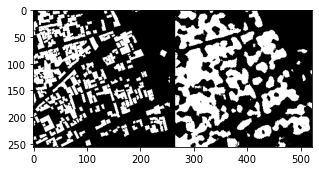

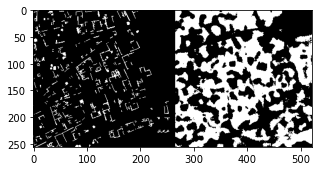

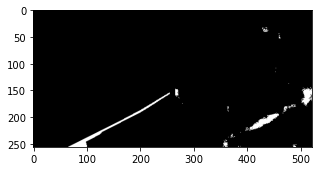

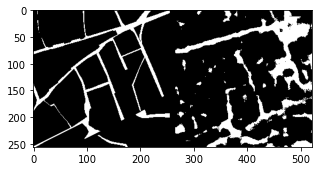

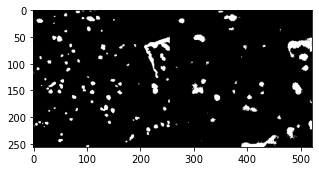

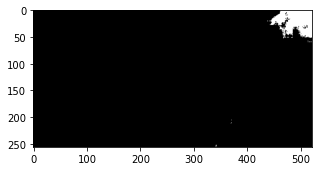

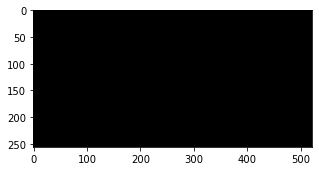

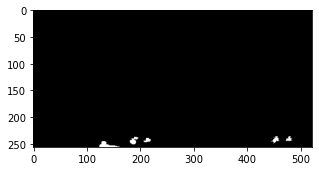

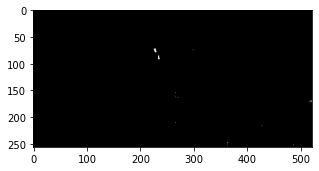

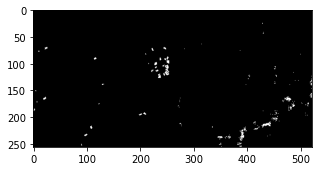

In [9]:
fcn_model.load_weights('saved_weights/baseline_weights/fcn_base.h5')

fcn_model.evaluate(data_generators[2])
iou = evaluate_iou(data_generators[2], fcn_model)
print(iou)
print(np.mean(iou))

fcn_prediction = fcn_model.predict(temp_p_img_patch)
fcn_tmp_p_masks = fcn_prediction[0]
fcn_tmp_p_masks[fcn_tmp_p_masks > 0.3] = 1
fcn_tmp_p_masks[fcn_tmp_p_masks <= 0.3] = 0

for i in range(10):
    maerged_mask = np.concatenate([temp_masks_patch[:,:,i], np.zeros((256,10)), fcn_tmp_p_masks[:,:,i]], axis=1)
    display_mask(maerged_mask)

### SegNet

In [10]:
from keras_segnet.segnet import SegNet

with strategy.scope():
    segnet_model = SegNet(
        input_shape=(256, 256, 8),
        classes=10
    )

    segnet_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=weighted_categorical_crossentropy(weights),
        metrics=['accuracy', calc_mean_iou]
    )

# segnet_history = segnet_model.fit(
#     data_generators[0],
#     epochs=200,
#     validation_data=data_generators[1]
# )

# plt.plot(segnet_history.history['loss'])

In [11]:
# segnet_model.save_weights('saved_weights/segnet_base.h5')

4/4 [==============================] - 0s 80ms/step - loss: 9.2941e-04 - accuracy: 0.4747 - categorical_accuracy: 0.4747 - calc_mean_iou: 0.1744
tf.Tensor(
[0.07037278 0.02267941 0.22287884 0.08256988 0.27978453 0.6364707
 0.3047077  0.12430587 0.00000079 0.00002492], shape=(10,), dtype=float32)
0.17437956


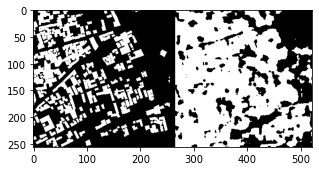

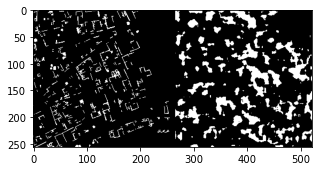

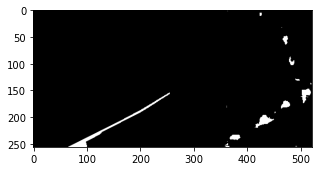

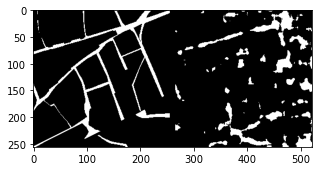

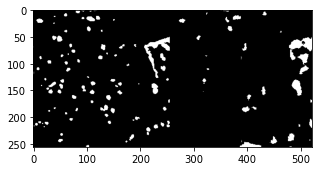

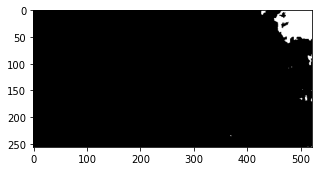

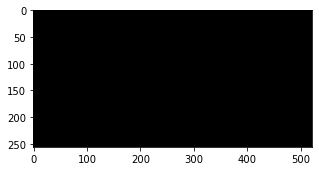

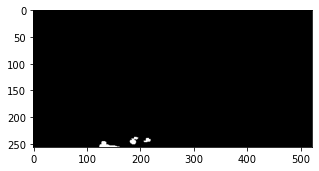

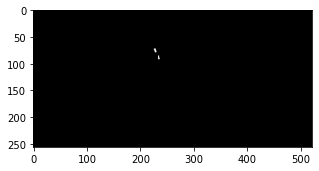

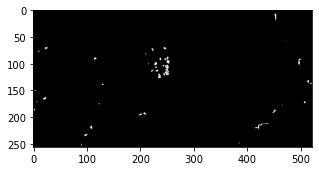

In [12]:
segnet_model.load_weights('saved_weights/baseline_weights/segnet_base.h5')

segnet_model.evaluate(data_generators[2])
iou = evaluate_iou(data_generators[2], segnet_model)
print(iou)
print(np.mean(iou))

segnet_prediction = segnet_model.predict(temp_p_img_patch)
segnet_tmp_p_masks = segnet_prediction[0]
segnet_tmp_p_masks[segnet_tmp_p_masks > 0.3] = 1
segnet_tmp_p_masks[segnet_tmp_p_masks <= 0.3] = 0

for i in range(10):
    maerged_mask = np.concatenate([temp_masks_patch[:,:,i], np.zeros((256,10)), segnet_tmp_p_masks[:,:,i]], axis=1)
    display_mask(maerged_mask)

### DeepLab V3 Plus

In [13]:
from keras_deeplab_v3_plus.model import Deeplabv3

with strategy.scope():
    deeplab_model = Deeplabv3(
        weights=None,
        input_shape=(256, 256, 8),
        classes=10,
        activation='softmax',
        backbone='xception',
        OS=16
    )

    deeplab_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=weighted_categorical_crossentropy(weights),
        metrics=['accuracy', calc_mean_iou]
    )

# deeplab_history = deeplab_model.fit(
#     data_generators[0],
#     epochs=200,
#     validation_data=data_generators[1]
# )

# plt.plot(deeplab_history.history['loss'])

In [14]:
# deeplab_model.save_weights('saved_weights/deeplab_base.h5')

4/4 [==============================] - 0s 119ms/step - loss: 4.8102e-04 - accuracy: 0.4339 - calc_mean_iou: 0.1863
tf.Tensor(
[0.16446061 0.0290053  0.22859007 0.07238697 0.24719724 0.5572568
 0.28966022 0.26749998 0.00247856 0.00493134], shape=(10,), dtype=float32)
0.18634671


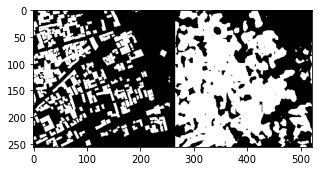

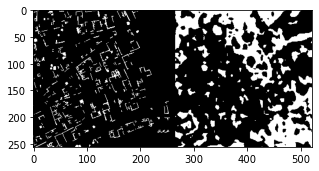

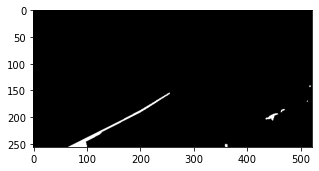

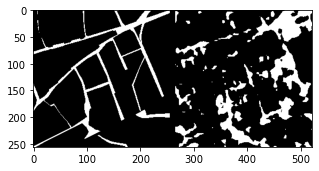

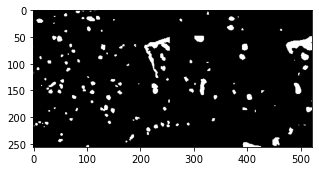

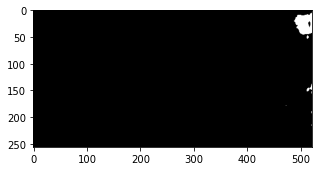

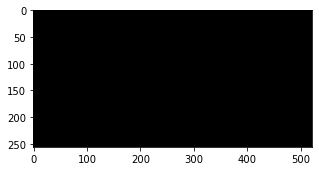

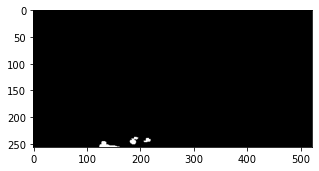

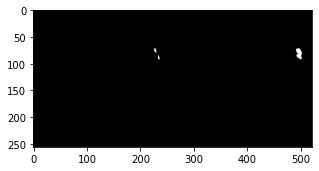

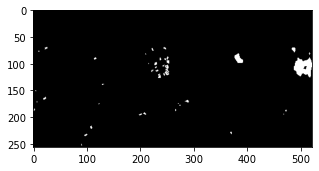

In [15]:
deeplab_model.load_weights('saved_weights/baseline_weights/deeplab_base.h5')
deeplab_model.evaluate(data_generators[2])
iou = evaluate_iou(data_generators[2], deeplab_model)
print(iou)
print(np.mean(iou))

deeplab_prediction = deeplab_model.predict(temp_p_img_patch)
deeplab_tmp_p_masks = deeplab_prediction[0]
deeplab_tmp_p_masks[deeplab_tmp_p_masks > 0.3] = 1
deeplab_tmp_p_masks[deeplab_tmp_p_masks <= 0.3] = 0

for i in range(10):
    maerged_mask = np.concatenate([temp_masks_patch[:,:,i], np.zeros((256,10)), deeplab_tmp_p_masks[:,:,i]], axis=1)
    display_mask(maerged_mask)